<a href="https://colab.research.google.com/github/MnCSSJ4x/Global-Warming-Detection/blob/main/Time_Series_Analysis_of_Land_Temperature_using_MODIS_DRAFT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of MODIS gap-filled temperature

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2DTranspose, Reshape
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.7 MB/s eta 0:00:00


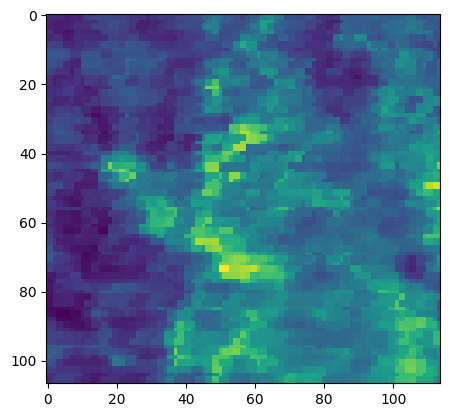

In [28]:
import rasterio
from matplotlib import pyplot as plt

# Open the GeoTIFF file using rasterio
with rasterio.open('drive/MyDrive/RE Work/500m_dataset.tif') as src:
    # Read the first band of the image as a NumPy array
    band1 = src.read(1)

    # Display the image using matplotlib
    plt.imshow(band1, cmap='viridis')
    plt.show()

raster = rasterio.open("drive/MyDrive/RE Work/500m_dataset.tif")
num_bands = raster.count
bands = [raster.read(i) for i in range(1,num_bands+1)]

### Current data is from 2003-2020 end

In [29]:
print('Number of Images: ', len(bands))

Number of Images:  216


### Converting Bands array to numpy array and then flattening it:

In [30]:
bands = np.array(bands)
bands = np.expand_dims(bands, axis=-1)
bands.shape

(216, 107, 114, 1)

In [31]:
flat_bands = bands.reshape(-1,216)
flat_bands.shape

(12198, 216)

### EDA

In [9]:
months = [str("M" + str(i)) for i in range(216)]

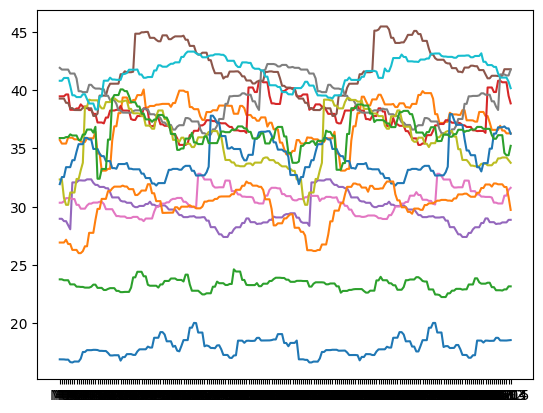

In [10]:
n = 12198
for i in range(0,n,1000):
  plt.plot(flat_bands[i,:])
plt.xticks(ticks = [i for i in range(216)], labels = months)
plt.show()

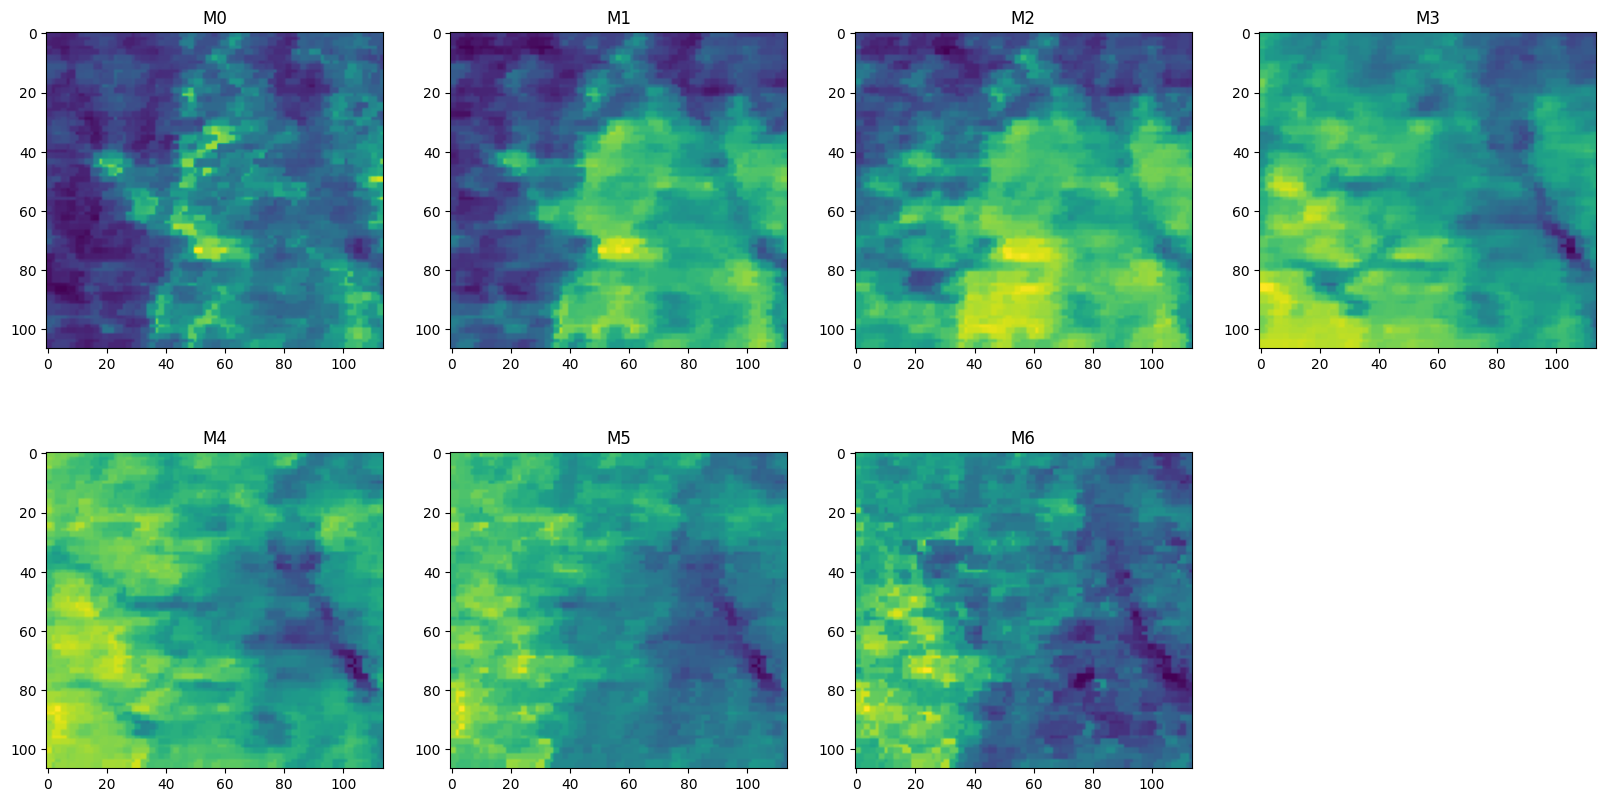

In [11]:
plt.figure(figsize = (20,10))
for i in range(7):
  plt.subplot(2,4,i+1)
  plt.imshow(bands[i,:,:])
  plt.xticks()
  plt.title(months[i])
plt.show()

In [12]:
scaler = StandardScaler()
scaler.fit(flat_bands)
print("Means before standardizing: ", scaler.mean_)
print("\nVariances before standardizing: ", scaler.var_)

X_scaled = scaler.transform(flat_bands)

print("\nMeans after standardizing: ", X_scaled.mean(axis=0))
print("\nVariances after standardizing: ", X_scaled.var(axis=0))

Means before standardizing:  [31.83804493 31.83648799 31.80382774 31.81508321 31.81114378 31.78940894
 31.84504723 31.85273681 31.82644067 31.82674759 31.82240907 31.79999644
 31.8573505  31.85351181 31.82644923 31.82888653 31.81543812 31.79862131
 31.85307449 31.85511844 31.81743357 31.8261584  31.81660951 31.79748462
 31.86017915 31.85498046 31.83344337 31.83489344 31.80650487 31.78598638
 31.83695975 31.83337697 31.79295801 31.79879282 31.78978519 31.77150887
 31.83168174 31.8415876  31.8080058  31.81103317 31.80063643 31.78103027
 31.84489448 31.84199612 31.81133376 31.82235171 31.80960789 31.7866461
 31.84675408 31.84651102 31.81792342 31.82883666 31.82589532 31.80596691
 31.87224266 31.87013951 31.83711573 31.84404107 31.81418972 31.78993781
 31.84302347 31.84268401 31.80274262 31.81639763 31.81192516 31.78979731
 31.84973645 31.85237924 31.82028273 31.82260221 31.80555769 31.78454899
 31.83944319 31.83627275 31.79540765 31.8017703  31.79455794 31.77880834
 31.84224275 31.8493457

## Probable Models to try
- CNN-LSTM/GRUs
- ConvLSTM
- 3D CNN

### Attempts on Flattened Bands

In [10]:
X_full = bands

In [11]:
X_flat = X_full.reshape(X_full.shape[0], X_full.shape[1]*X_full.shape[2])
X_flat = np.moveaxis(X_flat,1,0)
X_flat.shape

(12198, 216)

In [12]:
X = X_flat[:,0:214]

In [13]:
Y = X_flat[:,215]

In [14]:
X.shape

(12198, 214)

In [15]:
Y.shape

(12198,)

In [22]:
window_size = 24
#get sequence
X_seq = np.array([])
Y_seq = np.array([])
for i in range(window_size, X_flat.shape[1]):
  if X_seq.shape[0]==0:
    X_seq = X_flat[:,i-window_size:i]
  else:
    X_seq = np.vstack((X_seq,X_flat[:,i-window_size:i]))

  if Y_seq.shape[0]==0:
    Y_seq = X_flat[:,i]
  else:
    Y_seq = np.vstack((Y_seq,X_flat[:,i]))

In [23]:
X_seq = X_seq.reshape(-1,1)
Y_seq = Y_seq.reshape(-1,1)

In [24]:
Y_seq.shape

(2342016, 1)

In [25]:
X_seq.shape

(56208384, 1)

In [26]:
import gc
del bands
gc.collect()

3478

### CNN + LSTM

In [32]:
window_size = 10
#get sequence
X_seq = []
for i in range(window_size, len(bands)):
    X_seq.append(bands[i-window_size:i])

X_seq = np.array(X_seq)
X_seq.shape

(206, 10, 107, 114, 1)

In [33]:
height = 107
width = 114
channels = 1

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed

model = Sequential()

# Convolutional layers
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(window_size, height, width, channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# LSTM layer
model.add(TimeDistributed(Flatten()))
model.add(LSTM(1024))

# Dense layers
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(12198, activation='sigmoid'))
model.add(Reshape((height, width,1)))

In [56]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 105, 112, 32)  320      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 52, 56, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization (BatchN  (None, 10, 52, 56, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_23 (TimeDi  (None, 10, 50, 54, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 10, 25, 27, 64)  

In [63]:
model.fit(X_seq, bands[window_size:], batch_size=32, epochs=200)

Epoch 1/200
7/7 [==============================] - 2s 207ms/step - loss: 30.8127
Epoch 2/200
7/7 [==============================] - 1s 205ms/step - loss: 30.8127
Epoch 3/200
7/7 [==============================] - 1s 204ms/step - loss: 30.8127
Epoch 4/200
7/7 [==============================] - 1s 197ms/step - loss: 30.8127
Epoch 5/200
7/7 [==============================] - 1s 195ms/step - loss: 30.8127
Epoch 6/200
7/7 [==============================] - 1s 195ms/step - loss: 30.8127
Epoch 7/200
7/7 [==============================] - 1s 194ms/step - loss: 30.8127
Epoch 8/200
7/7 [==============================] - 1s 195ms/step - loss: 30.8127
Epoch 9/200
7/7 [==============================] - 1s 196ms/step - loss: 30.8127
Epoch 10/200
7/7 [==============================] - 1s 196ms/step - loss: 30.8127
Epoch 11/200
7/7 [==============================] - 1s 197ms/step - loss: 30.8127
Epoch 12/200
7/7 [==============================] - 1s 197ms/step - loss: 30.8127
Epoch 13/200
7/7 [=======

In [64]:
test_sample = np.array([X_seq[0]])
test_sample.shape
y_pred = model.predict(test_sample)
out = np.squeeze(y_pred[0])
out.shape

1/1 [==============================] - 0s 20ms/step


(107, 114)

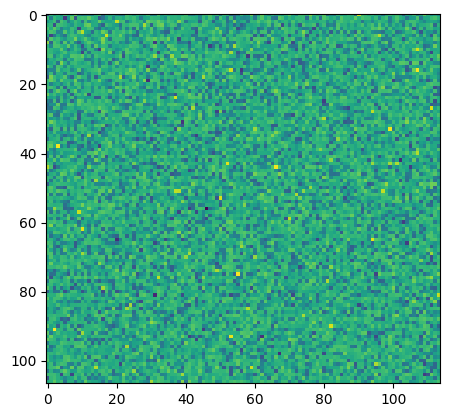

In [65]:
plt.imshow(out,cmap='viridis')
plt.show()

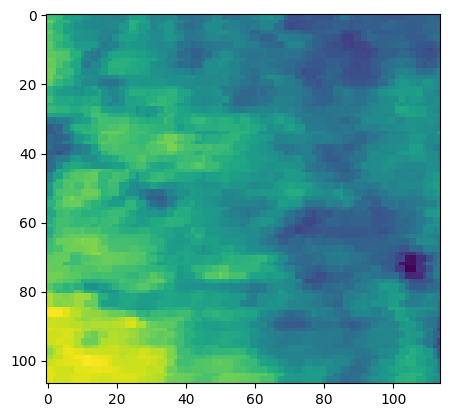

In [54]:
plt.imshow(bands[window_size],cmap='viridis')

### ConvLSTM

In [ ]:
window_size = 10
#get sequence
X_seq = []
for i in range(window_size, len(bands)):
    X_seq.append(bands[i-window_size:i])

X_seq = np.array(X_seq)
X_seq.shape

(206, 10, 107, 114, 1, 1)

In [ ]:
height = 107
width = 114
channels = 1

In [ ]:
print(width*height)

12198


In [ ]:
input_shape = (window_size, height,width,channels)

# Define the model
model = Sequential()

# Add ConvLSTM layer
# model.add(ConvLSTM2D(filters=32, kernel_size=(7, 7), input_shape=(window_size, height, width, channels), padding='same', return_sequences=True,dropout=0.4,activation='relu'))
# model.add(BatchNormalization())
# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True,activation='relu'))
# model.add(BatchNormalization())
# model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), padding='same', return_sequences=True,dropout=0.2,activation='relu'))
# model.add(BatchNormalization())
# model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', return_sequences=False,activation='sigmoid'))

model.add(ConvLSTM2D(filters=32, kernel_size=(7, 7),
                         input_shape=(window_size, height, width, 1),
                         return_sequences=True,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.4, recurrent_dropout=0.2
                         ))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(7, 7),
                         return_sequences=True,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.4, recurrent_dropout=0.2
                         ))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=8, kernel_size=(7, 7),
                         return_sequences=False,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.3, recurrent_dropout=0.2
                         ))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                   activation='relu',
                   data_format='channels_last'))


model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(8192, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(8192, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Dense(12198, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Reshape((height, width,1)))

# Compile the model
model.compile(loss='mae', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 101, 108, 32)  207104    
                                                                 
 batch_normalization (BatchN  (None, 10, 101, 108, 32)  128      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 95, 102, 16)   150592    
                                                                 
 batch_normalization_1 (Batc  (None, 10, 95, 102, 16)  64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 89, 96, 8)         37664     
                                                                 
 batch_normalization_2 (Batc  (None, 89, 96, 8)        3

In [ ]:
model.fit(X_seq, bands[window_size:], epochs=50, batch_size=16, validation_split=0.2, shuffle=True)

Epoch 1/50
11/11 [==============================] - 28s 2s/step - loss: 31.8952 - val_loss: 31.4769
Epoch 2/50
11/11 [==============================] - 16s 1s/step - loss: 31.8852 - val_loss: 31.4845
Epoch 3/50
11/11 [==============================] - 16s 1s/step - loss: 31.8745 - val_loss: 31.4919
Epoch 4/50
11/11 [==============================] - 15s 1s/step - loss: 31.8641 - val_loss: 31.4992
Epoch 5/50
11/11 [==============================] - 15s 1s/step - loss: 31.8522 - val_loss: 31.5064
Epoch 6/50
11/11 [==============================] - 15s 1s/step - loss: 31.8425 - val_loss: 31.5124
Epoch 7/50
11/11 [==============================] - 16s 1s/step - loss: 31.8309 - val_loss: 31.5186
Epoch 8/50
11/11 [==============================] - 16s 1s/step - loss: 31.8210 - val_loss: 31.5199
Epoch 9/50
11/11 [==============================] - 15s 1s/step - loss: 31.8107 - val_loss: 31.5138
Epoch 10/50
11/11 [==============================] - 15s 1s/step - loss: 31.7996 - val_loss: 31.4969

KeyboardInterrupt: ignored

In [ ]:
X_seq.shape

(206, 10, 107, 114, 1, 1)

In [ ]:
test_sample = np.array([X_seq[0]])
test_sample.shape

(1, 10, 107, 114, 1, 1)

In [ ]:
y_pred = model.predict(test_sample)

1/1 [==============================] - 0s 72ms/step


In [ ]:
out = np.squeeze(y_pred[0])
out.shape

(107, 114)

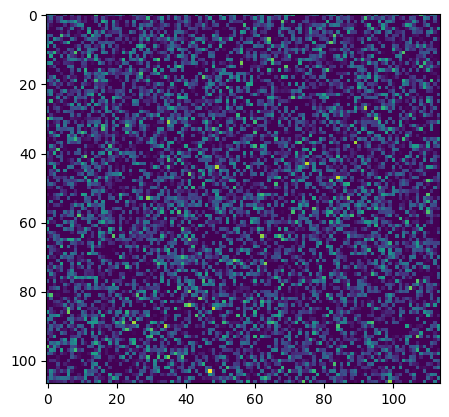

In [ ]:
plt.imshow(out, cmap='viridis')
plt.show()

TypeError: ignored

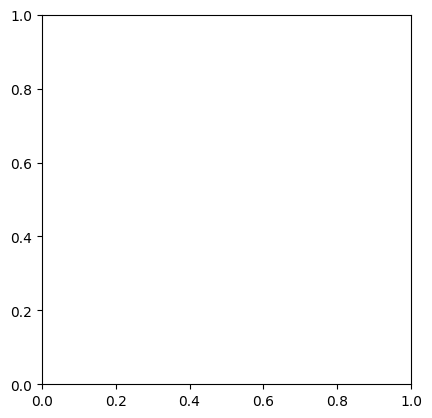

In [ ]:
plt.imshow(bands[0], cmap='viridis')
plt.show()

### CNN Linear Layer Based

In [ ]:
IMG_WIDTH = 107
IMG_HEIGHT = 114
EPOCHS = 100

def create_compile_model_with_bn_dropout_366():
  model = Sequential(
      [
        #seeing OK performance with fullsize images,
        #but preprocessing is an option if needed to make training faster.
        #preprocessing.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest"),
        preprocessing.Rescaling(1./255)
      ]
  )
  model.add(Conv2D(32, (7,7), padding='same', activation='selu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='selu'))
  model.add(Dense(1, activation='linear'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
  return model

In [ ]:
model = create_compile_model_with_bn_dropout_366()
d = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
checkpoint_filename = '/content/drive/MyDrive/TeamHurricane/models/best-' + d +'.h5'
checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
print(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %I:%M:%S %p"))

history = model.fit(batched_ds_train.repeat(), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, verbose=1, \
                    validation_data=batched_ds_val, callbacks=[checkpoint])

final_filename = '/content/drive/MyDrive/TeamHurricane/models/final-' + d + '.h5'
model.save(final_filename)
print("just saved model" )